# Twitter US Airline Sentiment 

### Background and Context:

Twitter possesses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other hand, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.


Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.

### Data Description:

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

#### Dataset:

The dataset has the following columns:

tweet_id                                                           
airline_sentiment                                               
airline_sentiment_confidence                               
negativereason                                                   
negativereason_confidence                                    
airline                                                                    
airline_sentiment_gold                                              
name     
negativereason_gold 
retweet_count
text
tweet_coord
tweet_created
tweet_location 
user_timezone

In [1]:
import re
import numpy as np                                
import pandas as pd 
import seaborn as sns
import nltk                                        
nltk.download('stopwords')   
nltk.download('punkt')

from nltk.corpus import stopwords                  
from nltk.stem import PorterStemmer                
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 

from sklearn.feature_extraction.text import CountVectorizer          
from sklearn.feature_extraction.text import TfidfVectorizer          

import re, string, unicodedata                          
import contractions                                    
from bs4 import BeautifulSoup                          

import matplotlib.pyplot as plt   
from sklearn.model_selection import KFold , StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier      
from sklearn.metrics import classification_report        
from sklearn.model_selection import cross_val_score      


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kayaf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kayaf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data=pd.read_csv("Tweets.csv")

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns")

There are 14640 rows and 15 columns


In [5]:
data.duplicated().sum() #There are 36 duplicated rows

36

In [6]:
df=data.copy()

In [7]:
df= df.drop_duplicates()

In [8]:
df.duplicated().sum()

0

In [9]:
df.isnull().sum() #There are many missing values on the  airline_sentiment_gold,negativereason_gold, tweet_coord columns. Let's drop the columns

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5445
negativereason_confidence        4101
airline                             0
airline_sentiment_gold          14564
name                                0
negativereason_gold             14572
retweet_count                       0
text                                0
tweet_coord                     13589
tweet_created                       0
tweet_location                   4723
user_timezone                    4814
dtype: int64

In [10]:
df.drop(["airline_sentiment_gold","negativereason_gold","tweet_coord"], axis=1, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14604 entries, 0 to 14639
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14604 non-null  int64  
 1   airline_sentiment             14604 non-null  object 
 2   airline_sentiment_confidence  14604 non-null  float64
 3   negativereason                9159 non-null   object 
 4   negativereason_confidence     10503 non-null  float64
 5   airline                       14604 non-null  object 
 6   name                          14604 non-null  object 
 7   retweet_count                 14604 non-null  int64  
 8   text                          14604 non-null  object 
 9   tweet_created                 14604 non-null  object 
 10  tweet_location                9881 non-null   object 
 11  user_timezone                 9790 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 1.4+ MB


### EDA

C:\Users\kayaf\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


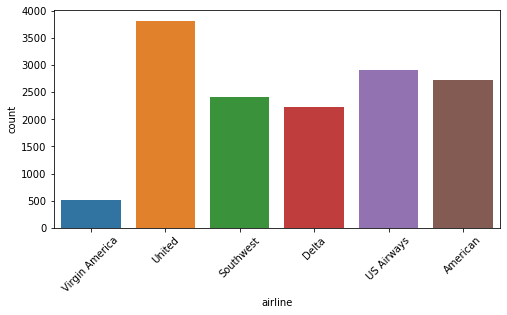

In [12]:
plt.figure(figsize=(8,4)) #Plot the distribution of all tweets among each airline.
sns.countplot(df["airline"])
plt.xticks(rotation=45)
plt.show()


C:\Users\kayaf\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


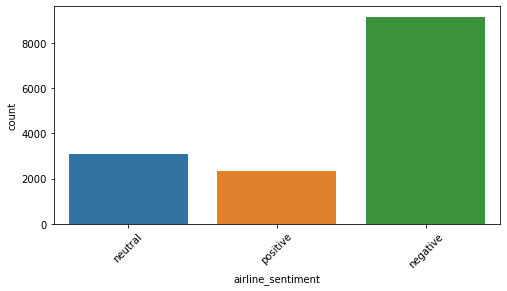

In [13]:
plt.figure(figsize=(8,4)) #plot the distribution of sentiment across all the tweets
sns.countplot(df["airline_sentiment"])
plt.xticks(rotation=45)
plt.show()

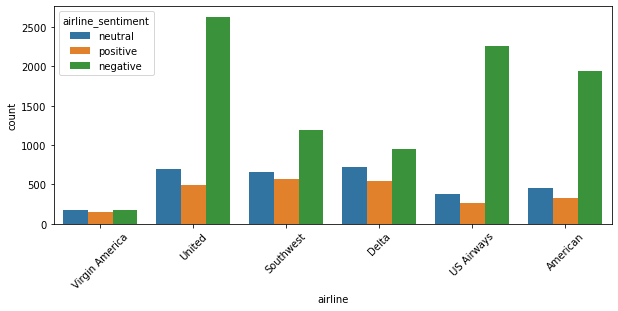

In [14]:
plt.figure(figsize=(10,4)) #Plot the distribution of Sentiment of tweets for each airline 
sns.countplot(data=df, x= "airline", hue="airline_sentiment")
plt.xticks(rotation=45)
plt.show()

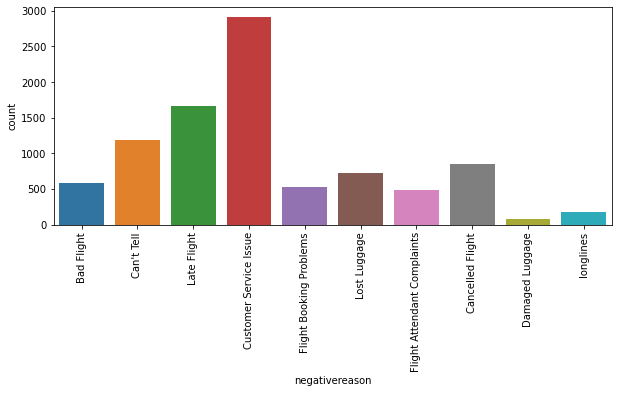

In [15]:
plt.figure(figsize=(10,4)) #plot the distribution of all the negative reasons
sns.countplot(data=df, x= "negativereason")
plt.xticks(rotation=90)
plt.show()

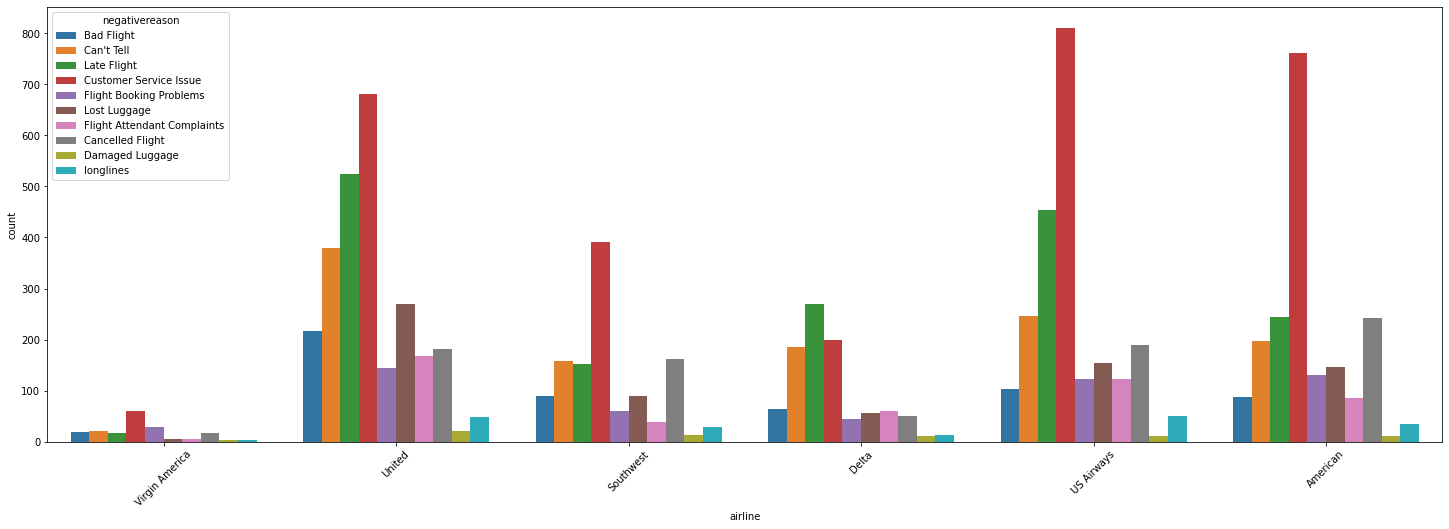

In [16]:
plt.figure(figsize=(25,8))
sns.countplot(data=df, x= "airline", hue="negativereason")
plt.xticks(rotation=45)
plt.show()

##### Observation

United Airline has more tweets than other airlines; Virgin America has the lowest number of tweets.
The number of negative tweets is higher than the number of neutral and positive tweets.
All airlines have higher negative tweets than positive and neutral tweets except Virgine America.
Customer service issue is the most frequent negative reason than the other negative reasons for all airlines except for delta. Late flight is the most frequent negative reason for Delta Airlines. 

##### Word Cloud for Negative Reviews

In [17]:
#pip install wordcloud

In [18]:
from wordcloud import WordCloud,STOPWORDS

In [19]:
negative_reviews=df[df['airline_sentiment']== "negative"]
words = ' '.join(negative_reviews['text'])
cleaned_word = " ".join([word for word in words.split()])

In [20]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2000
                     ).generate(cleaned_word)

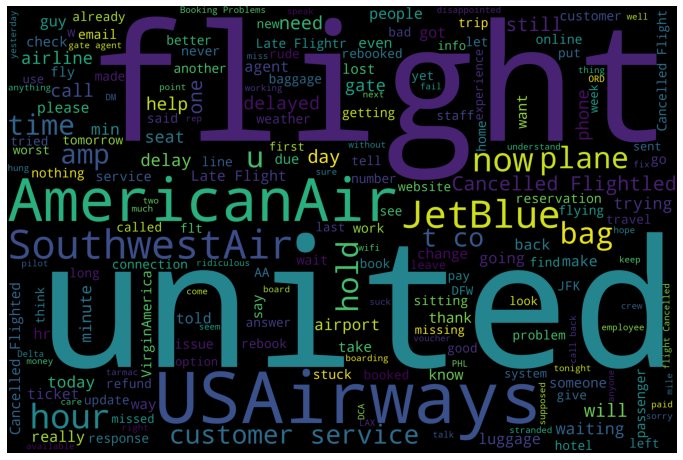

In [21]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

##### Word Cloud for Positive Reviews

In [22]:
positive_reviews=df[df['airline_sentiment']== "positive"]
words = ' '.join(positive_reviews['text'])
cleaned_word = " ".join([word for word in words.split()])

In [23]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2000
                     ).generate(cleaned_word)

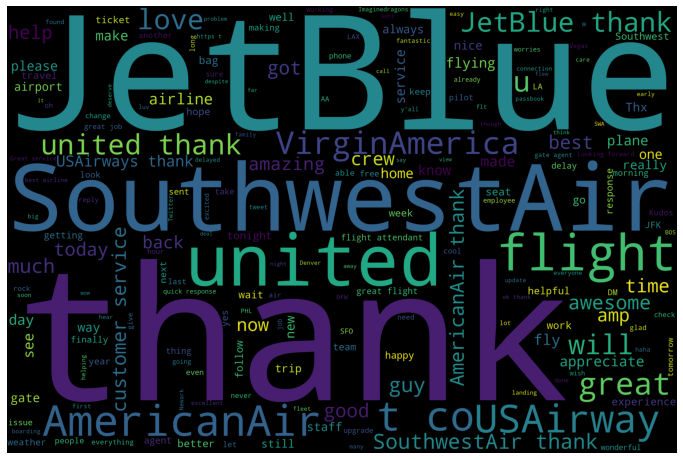

In [24]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Select “text” and “airline_sentiment” columns

In [25]:
df1= df[["airline_sentiment","text"]]

In [26]:
df1.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [27]:
df1.shape

(14604, 2)

### Text preprocessing

In [28]:
# remove html tag
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

#expand the contractions
def replace_contractions(text):
    return contractions.fix(text)

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text
#remove url in the text
def remove_url(text): 
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)
    return text

# remove mention
def remove_mention(text):
    text = re.sub(r'@\w+','',text)
    return text

def clean_text(text):
    text = strip_html(text)
    text = replace_contractions(text)
    text = remove_numbers(text)
    text= remove_url(text)
    text= remove_mention(text)
    return text
df1['text'] = df1['text'].apply(lambda x: clean_text(x))
df1.head()

<ipython-input-28-647e092bab76>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['text'] = df1['text'].apply(lambda x: clean_text(x))


,airline_sentiment,text
0,neutral,What said.
1,positive,plus you have added commercials to the experi...
2,neutral,I did not today... Must mean I need to take a...
3,negative,"it is really aggressive to blast obnoxious ""e..."
4,negative,and it is a really big bad thing about it


In [29]:
df1["text"] = df1.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1) # Tokenization of data

<ipython-input-29-49c85eab7085>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["text"] = df1.apply(lambda row: nltk.word_tokenize(row["text"]), axis=1) # Tokenization of data


In [30]:
df1.head()

,airline_sentiment,text
0,neutral,"[What, said, .]"
1,positive,"[plus, you, have, added, commercials, to, the,..."
2,neutral,"[I, did, not, today, ..., Must, mean, I, need,..."
3,negative,"[it, is, really, aggressive, to, blast, obnoxi..."
4,negative,"[and, it, is, a, really, big, bad, thing, abou..."


In [31]:
stopwords = stopwords.words('english')
stopwords = list(set(stopwords)) 
lemmatizer = WordNetLemmatizer()

#remove the non-ASCII characters
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
#Convert all characters to lowercase
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


# Remove the hashtags
def remove_hash(text):
   new_words = []
   for word in words:
     new_word = re.sub(r'#\w+','',word)
     if new_word != '':
       new_words.append(new_word)
   return new_words

# Remove the punctuations
def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Remove the stop words
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

df1['text'] = df1.apply(lambda row: normalize(row['text']), axis=1)

<ipython-input-31-35110ec4509f>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['text'] = df1.apply(lambda row: normalize(row['text']), axis=1)


In [32]:
df1.head()

,airline_sentiment,text
0,neutral,say
1,positive,plus add commercials experience tacky
2,neutral,today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainmen...
4,negative,really big bad thing


# Supervised Learning for Sentiment Analysis

### Bag of Words (CountVectorizer)

In [33]:
Count_vectorizer = CountVectorizer(max_features=2000)              
data_features = Count_vectorizer.fit_transform(df1["text"])

data_features = data_features.toarray()       

In [34]:
data_features.shape

(14604, 2000)

In [35]:
df1["sentiment"]=df1['airline_sentiment'].map({'negative':0,'neutral':1,'positive':2})

<ipython-input-35-a631d9e893ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["sentiment"]=df1['airline_sentiment'].map({'negative':0,'neutral':1,'positive':2})


In [36]:
df1.head()

,airline_sentiment,text,sentiment
0,neutral,say,1
1,positive,plus add commercials experience tacky,2
2,neutral,today must mean need take another trip,1
3,negative,really aggressive blast obnoxious entertainmen...,0
4,negative,really big bad thing,0


In [37]:
X= data_features
y= df1["sentiment"]

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [39]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)
count_vectorizer_predicted = rfc.predict(X_test)
print(classification_report(y_test ,count_vectorizer_predicted , target_names = ['0', '1' , '2']))
print("Accuracy of the model is : ",accuracy_score(y_test,count_vectorizer_predicted))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2088
           1       0.50      0.46      0.48       476
           2       0.65      0.63      0.64       357

    accuracy                           0.78      2921
   macro avg       0.67      0.66      0.66      2921
weighted avg       0.78      0.78      0.78      2921

Accuracy of the model is :  0.781239301609038


In [40]:
def confusion_matrix_classification(model, predictors, target):
    y_prediction = model.predict(predictors)
    cm = confusion_matrix(target, y_prediction)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(3, 3)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True")
    plt.xlabel("Predicted")

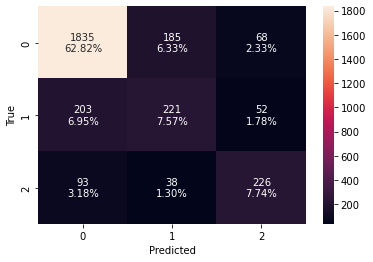

In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix_classification(rfc, X_test, y_test)


In [42]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
gbc.score(X_test, y_test)
count_vectorizer_predicted = gbc.predict(X_test)
print(classification_report(y_test ,count_vectorizer_predicted , target_names = ['0', '1' , '2']))
print("Accuracy of the model is : ",accuracy_score(y_test,count_vectorizer_predicted))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2088
           1       0.59      0.09      0.16       476
           2       0.65      0.64      0.64       357

    accuracy                           0.77      2921
   macro avg       0.68      0.56      0.56      2921
weighted avg       0.74      0.77      0.72      2921

Accuracy of the model is :  0.7726805888394386


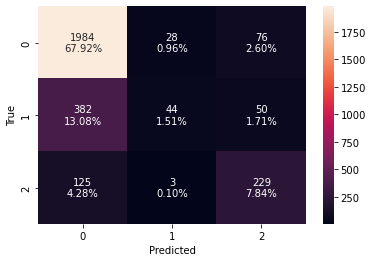

In [43]:
confusion_matrix_classification(gbc, X_test, y_test)

### Term Frequency - Inverse Document Frequency (TF-IDF)

In [44]:
tfidf_vect = TfidfVectorizer(max_features=2000)
data_features = tfidf_vect.fit_transform(df1['text'])

data_features = data_features.toarray()

data_features.shape

(14604, 2000)

In [45]:
X = data_features

y = df1["sentiment"]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [47]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)
tf_idf_predicted = rfc.predict(X_test)
print(classification_report(y_test , tf_idf_predicted , target_names = ['0', '1' , '2']))
print("Accuracy of the model is : ",accuracy_score(y_test,tf_idf_predicted))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2088
           1       0.58      0.47      0.52       476
           2       0.72      0.60      0.66       357

    accuracy                           0.81      2921
   macro avg       0.72      0.66      0.69      2921
weighted avg       0.79      0.81      0.80      2921

Accuracy of the model is :  0.8058883943854844


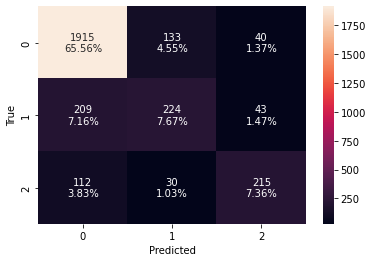

In [48]:
confusion_matrix_classification(rfc, X_test, y_test)

In [49]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
gbc.score(X_test, y_test)
tf_idf_predicted = gbc.predict(X_test)
print(classification_report(y_test , tf_idf_predicted , target_names = ['0', '1' , '2']))
print("Accuracy of the model is : ",accuracy_score(y_test,tf_idf_predicted))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      2088
           1       0.60      0.11      0.18       476
           2       0.68      0.62      0.65       357

    accuracy                           0.78      2921
   macro avg       0.69      0.56      0.57      2921
weighted avg       0.75      0.78      0.73      2921

Accuracy of the model is :  0.7788428620335501


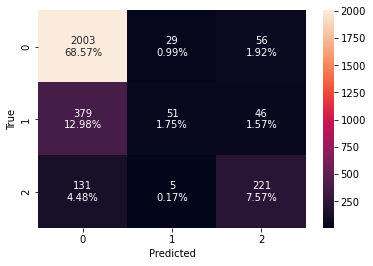

In [50]:
confusion_matrix_classification(gbc, X_test, y_test)

### Conclusion

The number of negative tweets is higher than the number of neutral and positive tweets. All airlines have higher negative tweets than positive and neutral tweets except Virgine America. Customer service issue is the most frequent negative reason than the other negative reasons for all airlines except for Delta Airline. 
Gradient Boosting and Random Forest models were used to classify the text. Encoding text with TF-IDF using the Random Forest model performed better than the other models. SMOTE can be used to balance the target variable. The negative reason column can be merged with the text column to enrich the text, and the models can be run using the merged column. 